In [1]:
!pip install networkx
!pip install pylatexenc
!pip install qiskit
!pip install qiskit_ibm_runtime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136818 sha256=44ad738f760cbe4d9ae2277b94a54d2afd969db19813c06e76cd15a8833448bc
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [21]:
import networkx as nx
import numpy as np
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import Parameter
from qiskit.circuit.library import QAOAAnsatz
from qiskit.tools.visualization import circuit_drawer
from qiskit.visualization import plot_distribution

# IBM Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Estimator, Sampler, Session

from scipy.optimize import minimize

{(0, 1): Text(-0.375, -0.375, '4'),
 (0, 2): Text(-0.375, -0.21875, '4'),
 (0, 3): Text(-0.375, -0.06250000000000003, '4'),
 (0, 4): Text(-0.375, 0.09375, '4')}

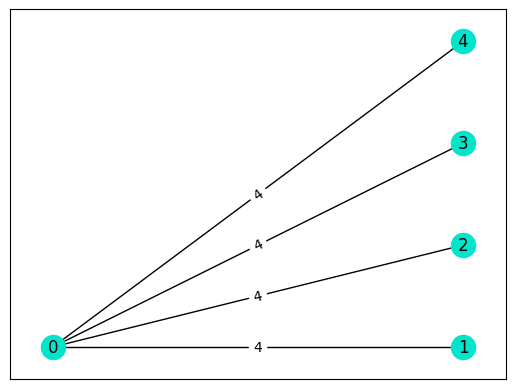

In [36]:
edges = [(0, 1, 1), (0, 2, 1), (0, 3, 1), (0, 4, 1)]
num_nodes = 5

G = nx.Graph()
G.add_nodes_from(range(num_nodes))
G.add_weighted_edges_from(edges)
pos=nx.bipartite_layout(G, {0})
nx.draw_networkx(G,pos, node_color="#00e5cc")
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

In [14]:
service = QiskitRuntimeService(channel="ibm_quantum", token = "978fe81e50b180aaeee04220db7759c64bd079be87c78e66084a3bb3a7e594275ef2521d3b6ec0d11d56ef606edb137b0ffadbbb3d1b88c262e7fd0f79c206e7")
backend = service.get_backend("ibmq_qasm_simulator")


Now the cost hamiltonian:

$H_c = \sum_{i, j = 1}^{5} \frac{-W_{ij}}{4} Z_iZ_j$

$e^{-i\gamma H_c} = \prod_{i,j=1}^{n} R_{Z_iZ_j}(2\gamma)$

And for mixer hamiltonian:

$H_m = \sum_{i =1}^{n} X_i$

$e^{-i\beta H_m} = \prod_{i=1}^{n} R_x(2\beta)$

And we are going to vary parameters $\beta$ and $\gamma$


In [85]:
gamma = 2 * np.pi * np.random.rand(2)
beta = 2 * np.pi * np.random.rand(2)

In [94]:
def add_hamiltonian(qc, n):
  for i in range(n):
    qc.h(i)

def add_hamiltnoian(qc, params, layers, n):
  for l in range(layers):
    for i in range(1, n):
      qc.rzz(params[l], 0, i)

    for j in range(0, n):
      qc.rx(params[l+2], j)


/usr/local/lib/python3.10/dist-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


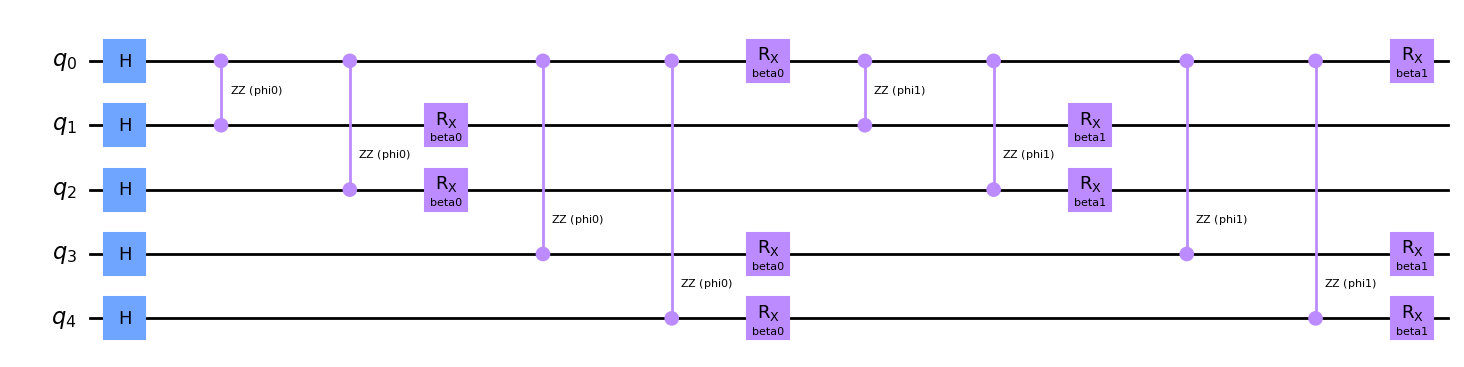

In [96]:
n = 5
layers = 2
params = []

for l in range(layers):
  params.append(Parameter('phi'+str(l)))

for l in range(layers):
  params.append(Parameter('beta'+str(l)))

ansatz = QuantumCircuit(n)
add_hamiltonian(ansatz, n)
add_hamiltnoian(ansatz, params, layers, n)

ansatz.draw("mpl")

In [97]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return cost

In [98]:
session = Session(backend=backend)

estimator = Estimator(session=session, options={"shots": int(10)})
sampler = Sampler(session=session, options={"shots": int(10)})

In [90]:
x0 = 2 * np.pi * np.random.rand(ansatz.num_parameters)
print(x0)

res = minimize(cost_func, x0, args=(ansatz, hamiltonian, estimator), method="COBYLA")

[5.41685785 4.18619356 6.11335295 5.69820846]


In [91]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.5999999999999999
       x: [ 5.516e+00  4.153e+00  6.366e+00  5.760e+00]
    nfev: 47
   maxcv: 0.0

In [92]:
qc = ansatzQAOA.assign_parameters(res.x)
# Add measurements to our circuit
qc.measure_all()

samp_dist = sampler.run(qc, shots=int(1e4)).result().quasi_dists[0]
# Close the session since we are now done with it
session.close()

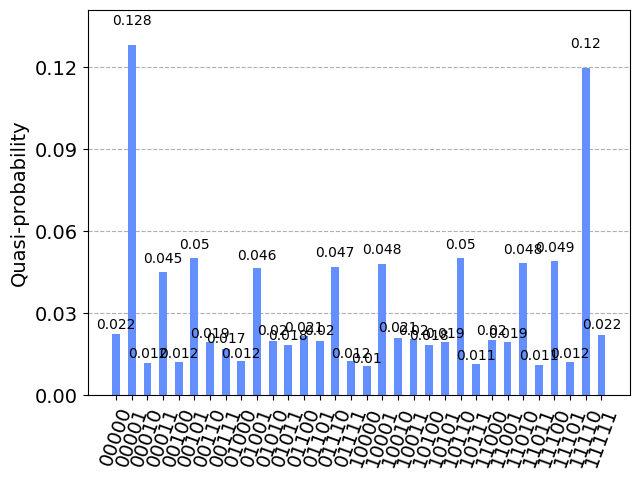

In [93]:
plot_distribution(samp_dist.binary_probabilities())
